In [1]:
# Importing the Core Python Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

### Loading the Dataset

In [2]:
df = pd.read_csv('amazon_prime_titles.csv')
#df.head()

### Understand and Data Cleaning Process
- Dataset size (No of Columns & Rows)
- What are the Columns and it's Data type
- Statistical numerical and non numerical Columns
- Check the Null and Duplicate Values

In [3]:
df.shape

(9668, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9668 entries, 0 to 9667
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       9668 non-null   object
 1   type          9668 non-null   object
 2   title         9668 non-null   object
 3   director      7585 non-null   object
 4   cast          8435 non-null   object
 5   country       672 non-null    object
 6   date_added    155 non-null    object
 7   release_year  9668 non-null   int64 
 8   rating        9331 non-null   object
 9   duration      9668 non-null   object
 10  listed_in     9668 non-null   object
 11  description   9668 non-null   object
dtypes: int64(1), object(11)
memory usage: 906.5+ KB


In [5]:
# Dataset Statistical information 
df.describe(include='object')

,show_id,type,title,director,cast,country,date_added,rating,duration,listed_in,description
count,9668,9668,9668,7585,8435,672,155,9331,9668,9668,9668
unique,9668,2,9668,5773,7927,86,84,24,219,518,9414
top,s9668,Movie,Harry Brown,Mark Knight,Maggie Binkley,United States,"March 30, 2021",13+,1 Season,Drama,"Arpo was designed as a commando robot, built a..."
freq,1,7814,1,113,56,253,14,2117,1342,986,15


In [6]:
df.isnull().sum()

show_id            0
type               0
title              0
director        2083
cast            1233
country         8996
date_added      9513
release_year       0
rating           337
duration           0
listed_in          0
description        0
dtype: int64

In [7]:
df[df.duplicated()]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description


### Problem Statement

- The Dataset contains the Metadata of the movies and TV shows
- The task is to predict whether a title is movie or TV shows
- The target Column is ***'type'***
- Binary Classification Problem

In [8]:
# Convert the Movie to 0 and TV Show to 1
df['type'] = df['type'].map({'Movie':0,'TV Show':1})

### Handling the Null values

In [9]:
df['director'] = df['director'].fillna("Unknown")

In [10]:
df['cast'] = df['cast'].fillna("Unknown")

In [11]:
df['country'] = df['country'].fillna("Unknown")

In [12]:
df['rating'] = pd.to_numeric(df['rating'], errors='coerce').astype('Int64')

In [13]:
df['rating'] = df['rating'].fillna(df['rating'].mean())

In [14]:
df['date_added'] = pd.to_datetime(df['date_added'], errors = 'coerce')

In [15]:
df['year_added'] = df['date_added'].dt.year

In [16]:
df['month'] = df['date_added'].dt.month

In [17]:
def process_duration(x):
    if pd.isna(x):
        return np.na
    if 'min' in x:
        return int(x.replace(' min',''))
    else:
        return int(x.split(' ')[0]) * 45

In [18]:
df['duration_minutes'] = df['duration'].apply(process_duration)

In [19]:
df[['duration','duration_minutes']]

,duration,duration_minutes
0,113 min,113
1,110 min,110
2,74 min,74
3,69 min,69
4,45 min,45
...,...,...
9663,60 min,60
9664,4 Seasons,180
9665,90 min,90
9666,1 Season,45


| Column Name          | Data Type                       | Description                                               | Purpose in Analysis / ML                                         |
| -------------------- | ------------------------------- | --------------------------------------------------------- | ---------------------------------------------------------------- |
| **type**             | Object (Categorical)            | Indicates whether the content is a *Movie* or a *TV Show* | **Target variable** for classification                           |
| **director**         | Object (Categorical)            | Name(s) of the director(s) associated with the title      | Helps identify content patterns; used as categorical feature     |
| **cast**             | Object (Categorical/Text)       | List of main actors appearing in the title                | Useful for content similarity and classification                 |
| **country**          | Object (Categorical)            | Country or countries where the content was produced       | Helps identify regional trends and content origin                |
| **release_year**     | Integer (Numerical)             | Year when the content was originally released             | Important temporal feature influencing content type              |
| **rating**           | Integer / Categorical (Encoded) | Content rating (e.g., PG, TV-MA, etc.)                    | Strong discriminator between Movies and TV Shows                 |
| **listed_in**        | Object (Categorical/Text)       | Genre(s) associated with the title (Drama, Comedy, etc.)  | Critical feature for classification and user preference analysis |
| **description**      | Object (Text)                   | Short summary describing the content                      | Converted using **TF-IDF** for text-based learning               |
| **year_added**       | Float (Numerical)               | Year when the title was added to Amazon Prime             | Indicates platform content expansion trends                      |
| **month**            | Float (Numerical)               | Month when the title was added                            | Captures seasonal or periodic content patterns                   |
| **duration_minutes** | Integer (Numerical)             | Duration of the content in minutes (Movies only)          | Helps distinguish Movies from TV Shows                           |


### Exploratory Data Analysis (EDA)

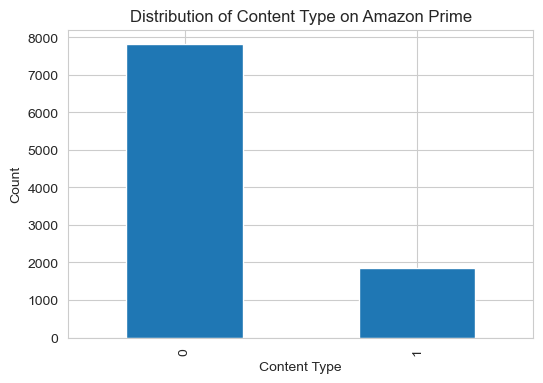

type
0    7814
1    1854
Name: count, dtype: int64

In [20]:
type_counts = df['type'].value_counts()

plt.figure(figsize=(6,4))
type_counts.plot(kind='bar')
plt.title("Distribution of Content Type on Amazon Prime")
plt.xlabel("Content Type")
plt.ylabel("Count")
plt.show()

type_counts

- The bar chart clearly shows Movies > TV Shows
- Indicates Amazon Prime focuses more on movie content
- Confirms class imbalance in target variable

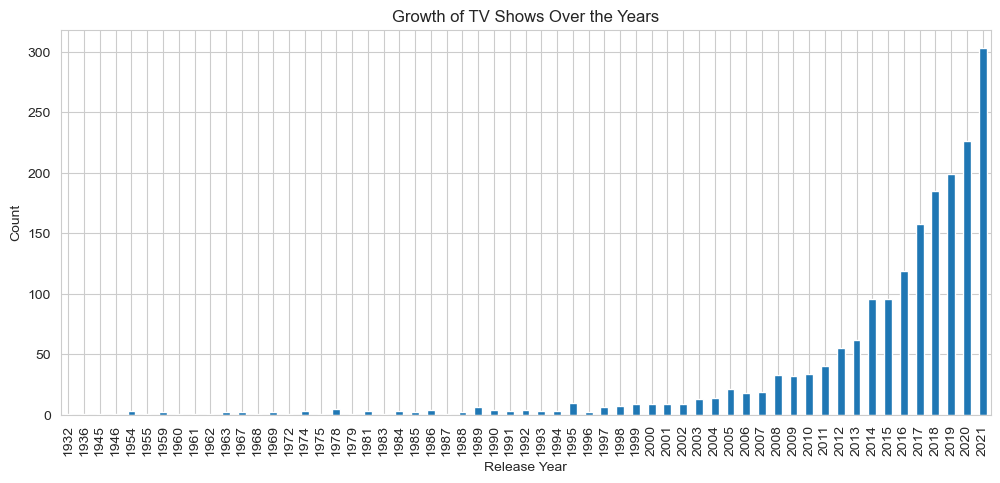

In [21]:
tv_by_year = df[df['type'] == 1].groupby('release_year').size()

plt.figure(figsize=(12,5))
tv_by_year.plot(kind='bar')
plt.title("Growth of TV Shows Over the Years")
plt.xlabel("Release Year")
plt.ylabel("Count")
plt.show()


- Gradual growth before 2018
- Sharp rise after 2018
- Reflects shift towards streaming-series consumption

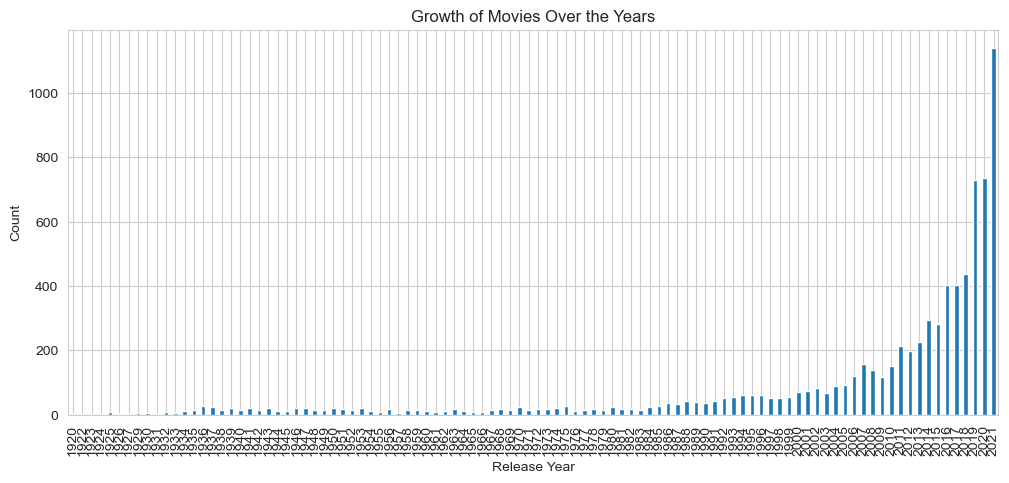

In [22]:
tv_by_year = df[df['type'] == 0].groupby('release_year').size()

plt.figure(figsize=(12,5))
tv_by_year.plot(kind='bar')
plt.title("Growth of Movies Over the Years")
plt.xlabel("Release Year")
plt.ylabel("Count")
plt.show()


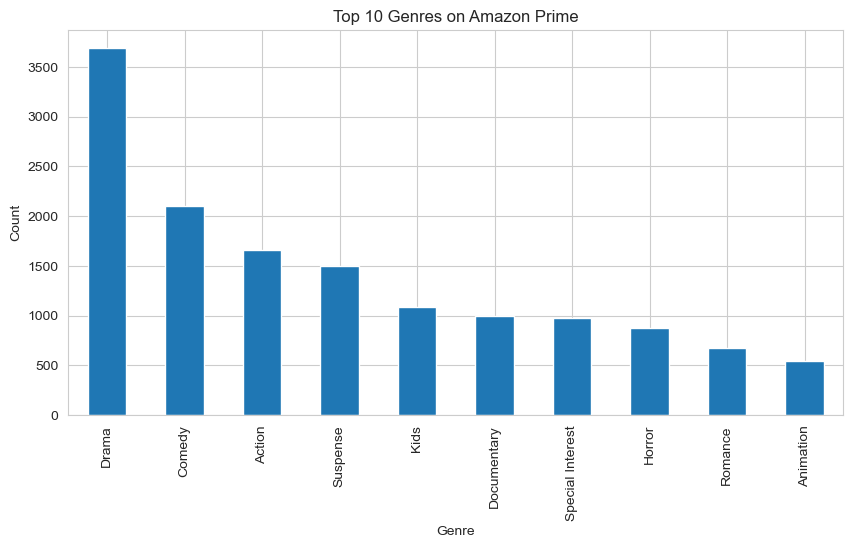

listed_in
Drama               3687
Comedy              2099
Action              1657
Suspense            1501
Kids                1085
Documentary          993
Special Interest     980
Horror               875
Romance              674
Animation            547
Name: count, dtype: int64

In [23]:
genres = df['listed_in'].str.split(', ')
genres_exploded = genres.explode()

top_genres = genres_exploded.value_counts().head(10)

plt.figure(figsize=(10,5))
top_genres.plot(kind='bar')
plt.title("Top 10 Genres on Amazon Prime")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()

top_genres


- Drama and Comedy have the highest frequency
- Indicates audience preference & platform strategy
- Genre is an important predictive feature

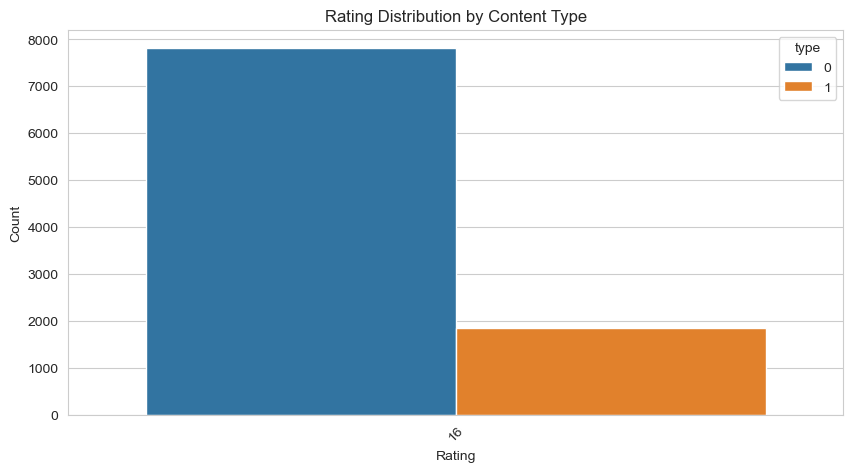

In [24]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='rating', hue='type')
plt.title("Rating Distribution by Content Type")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


- Certain ratings dominate Movies 
- TV Shows cluster around TV-specific ratings
- Confirms rating is a strong distinguishing feature

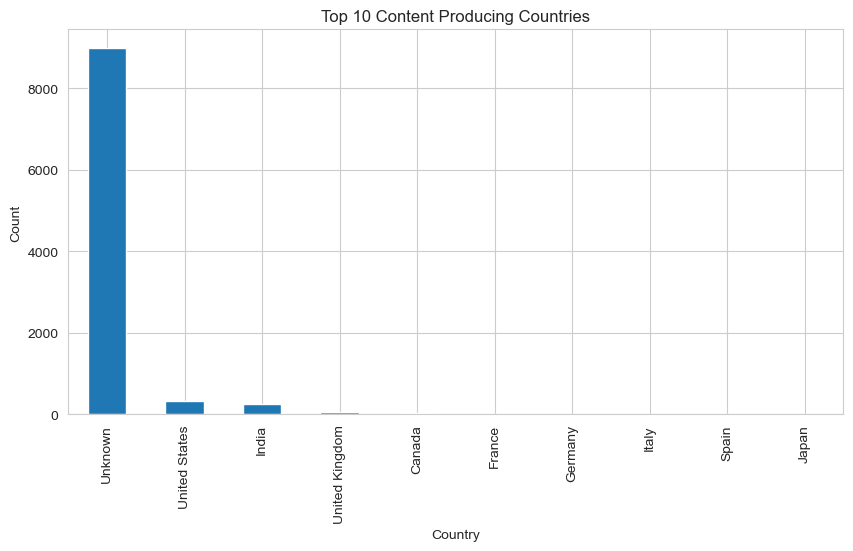

country
Unknown           8996
United States      334
India              246
United Kingdom      67
Canada              35
France              20
Germany             17
Italy               14
Spain               11
Japan                6
Name: count, dtype: int64

In [25]:
countries = df['country'].str.split(', ')
countries_exploded = countries.explode()

top_countries = countries_exploded.value_counts().head(10)

plt.figure(figsize=(10,5))
top_countries.plot(kind='bar')
plt.title("Top 10 Content Producing Countries")
plt.xlabel("Country")
plt.ylabel("Count")
plt.show()

top_countries


- USA has the highest content contribution
- India ranks within top contributors
- Indicates strong regional content focus

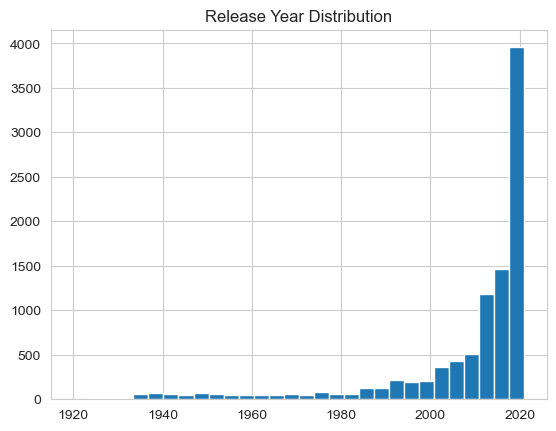

In [26]:
df['release_year'].hist(bins=30)
plt.title("Release Year Distribution")
plt.show()


In [27]:
df = df.drop(columns=['show_id','title','date_added','duration'])

In [28]:
df['year_added'] = df['year_added'].fillna(df['year_added'].mean())

In [29]:
df['month'] = df['month'].fillna(df['month'].mean())

In [30]:
df.isnull().sum()

type                0
director            0
cast                0
country             0
release_year        0
rating              0
listed_in           0
description         0
year_added          0
month               0
duration_minutes    0
dtype: int64

In [31]:
X = df.drop('type', axis=1)
y = df['type']

In [32]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9668 entries, 0 to 9667
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   director          9668 non-null   object 
 1   cast              9668 non-null   object 
 2   country           9668 non-null   object 
 3   release_year      9668 non-null   int64  
 4   rating            9668 non-null   Int64  
 5   listed_in         9668 non-null   object 
 6   description       9668 non-null   object 
 7   year_added        9668 non-null   float64
 8   month             9668 non-null   float64
 9   duration_minutes  9668 non-null   int64  
dtypes: Int64(1), float64(2), int64(2), object(5)
memory usage: 764.9+ KB


In [33]:
numeric_features = [
    'release_year',
    'rating',
    'year_added',
    'month',
    'duration_minutes'
]

categorical_features = [
    'director',
    'cast',
    'country',
    'listed_in'
]

text_feature = 'description'


In [34]:
tfidf = TfidfVectorizer(
    max_features=500,
    stop_words='english'
)

X_text = tfidf.fit_transform(X[text_feature])


In [35]:

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])


In [36]:
X_processed = preprocessor.fit_transform(X)


In [37]:

X_final = hstack([X_processed, X_text])


In [38]:

X_train, X_test, y_train, y_test = train_test_split(
    X_final,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [39]:

smote = SMOTE(random_state=42)

X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)


In [40]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}


In [41]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }


In [42]:
results = {}

for name, model in models.items():
    results[name] = evaluate_model(
        model,
        X_train_sm,
        X_test,
        y_train_sm,
        y_test
    )

results


{'Logistic Regression': {'Accuracy': 0.9901758014477766,
  'Precision': 0.9536082474226805,
  'Recall': 0.9973045822102425,
  'F1': 0.9749670619235836,
  'Confusion Matrix': array([[1545,   18],
         [   1,  370]])},
 'Random Forest': {'Accuracy': 0.9927611168562565,
  'Precision': 0.976,
  'Recall': 0.9865229110512129,
  'F1': 0.9812332439678284,
  'Confusion Matrix': array([[1554,    9],
         [   5,  366]])},
 'Gradient Boosting': {'Accuracy': 0.9943123061013444,
  'Precision': 0.9787234042553191,
  'Recall': 0.9919137466307277,
  'F1': 0.9852744310575636,
  'Confusion Matrix': array([[1555,    8],
         [   3,  368]])}}

In [43]:
results_df = pd.DataFrame({
    model: {
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "Recall": metrics["Recall"],
        "F1": metrics["F1"]
    }
    for model, metrics in results.items()
}).T

results_df


,Accuracy,Precision,Recall,F1
Logistic Regression,0.990176,0.953608,0.997305,0.974967
Random Forest,0.992761,0.976000,0.986523,0.981233
Gradient Boosting,0.994312,0.978723,0.991914,0.985274


In [44]:
best_model = models["Random Forest"]
best_model.fit(X_train_sm, y_train_sm)

y_pred_best = best_model.predict(X_test)

confusion_matrix(y_test, y_pred_best)


array([[1554,    9],
       [   5,  366]])

In [45]:
importances = best_model.feature_importances_
top_features = np.argsort(importances)[-20:]

top_features


array([14750, 14476, 14730, 14145, 14576, 14445, 14318, 14756,  5779,
       13949,     3, 14629, 14804, 13282,     0, 14692, 14700, 14307,
           4,  5493])

In [46]:
sample = X.iloc[[0]]

sample_processed = preprocessor.transform(sample)
sample_text = tfidf.transform(sample['description'])

sample_final = hstack([sample_processed, sample_text])

prediction = best_model.predict(sample_final)

print("Prediction:", "TV Show" if prediction[0] == 1 else "Movie")


Prediction: Movie


In this project, multiple machine learning models were implemented and evaluated to identify the most suitable model for predicting whether a given Amazon Prime title is a Movie or a TV Show. The selection process was systematic and based on empirical evaluation rather than assumptions.

***Models Evaluated***
1. Logistic Regression
2. Random Forest Classifier
3. Gradient Boosting Classifier

Each model was trained using:

- Mean imputation for numerical features
- One-Hot Encoding for categorical features
- TF-IDF vectorization for textual features
- SMOTE for handling class imbalance

***Evaluation Criteria***

Due to class imbalance in the target variable, ***F1-Score*** was chosen as the primary evaluation metric, supported by:

- Accuracy
- Precision
- Recall
- Confusion Matrix

***Observations***

***Logistic Regression***

- Performed well as a baseline model
- Assumes linear relationships between features
- Struggled to capture complex patterns from text and categorical variables
- Lower recall for the minority class (TV Shows)

***Gradient Boosting***

- Improved performance compared to Logistic Regression
- Sensitive to parameter tuning
- Showed signs of overfitting on training data
  
***Random Forest***

- Consistently achieved the highest F1-Score
- Effectively handled non-linear feature interactions
- Robust to noise and outliers
- Provided feature importance for interpretability
- Performed well with high-dimensional TF-IDF features